<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning-project/blob/main/part_1/3_ML_Project_Politiecontroles_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

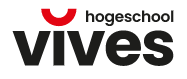<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# **Project Politiecontroles: Modeling**




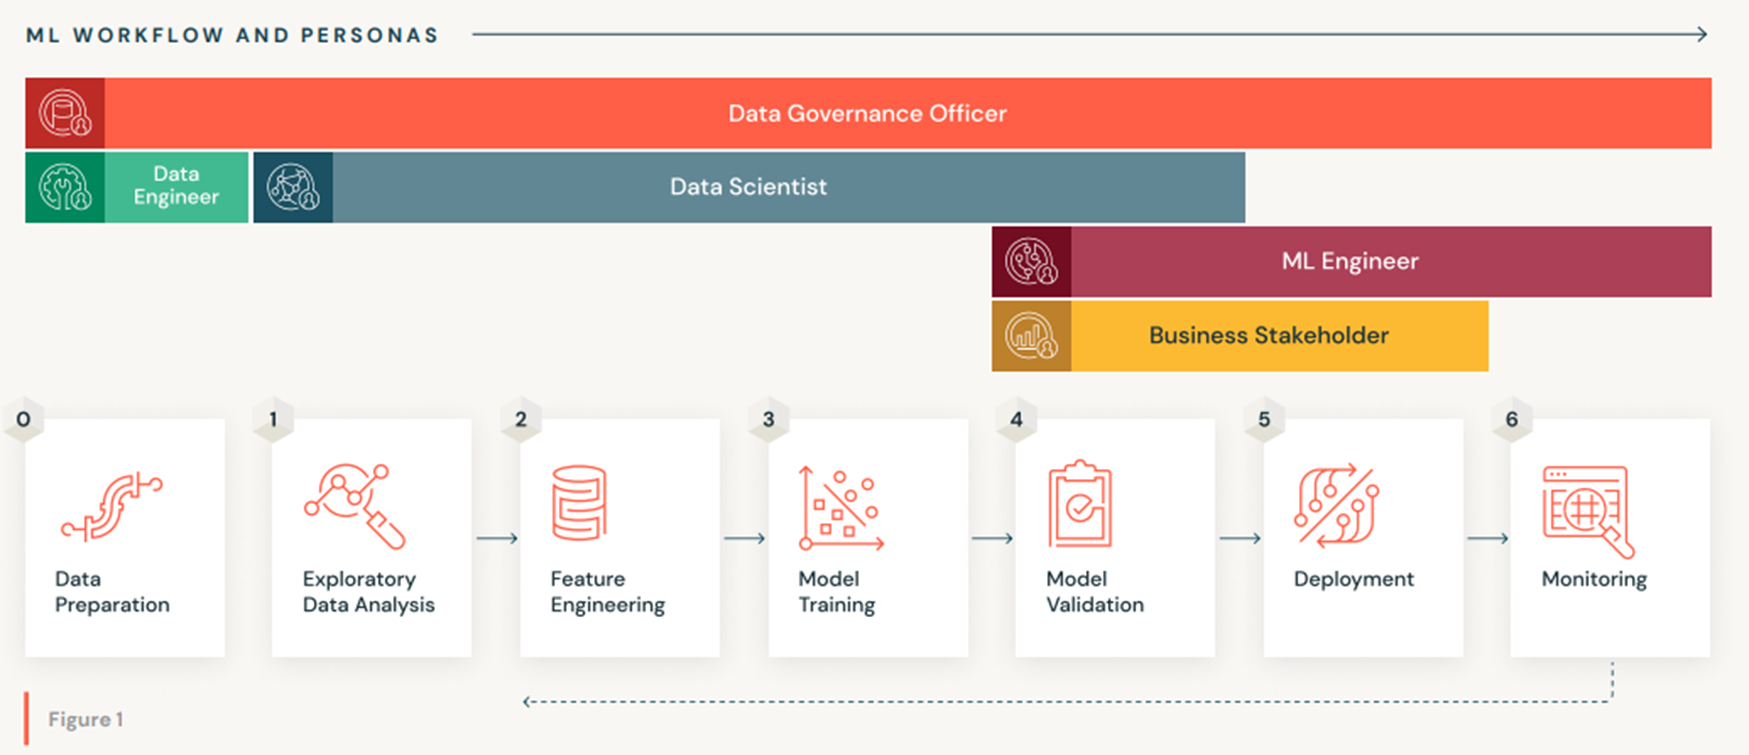

In dit project maken we dus gebruik van een dataset met politiedata die gekoppeld is aan weerdata. De datasets zijn ook terug te vinden op [Kaggle](https://www.kaggle.com/).

In de vorige fasen hebben we de data klaargemaakt en verkend en nu zijn we klaar om er effectief machine learning op toe te passen. Dit is de fase van het **modelleren**. Op de figuur hierboven komt dat overeen met stappen 3 en 4. We moeten ook een stuk van stap 2 opnieuw doen, de feature engineering.

## Feature engineering

We lezen opnieuw de opgekuiste dataset in die we opgeslagen hebben als `'police_controls.csv'`, en we slaan het resulterende Pandas `DataFrame` op in variabele `df`. We checken ook de eerste records om te zien of de file correct is ingeladen, en we roepen methode `info()` aan om een overzicht van de kolommen te krijgen. Normaal gezien zijn er 18 kolommen en elke kolom bevat 86137 non-null waarden.

We creëren een extra kolom `'Speeding'` met label `True` als variabele `'violation'` gelijk is aan `'Speeding'`, en label `False` in alle andere gevallen.

Uiteraard moeten we nu de kolom `'violation'` weggooien. Uit de EDA herinneren we ons dat kolom `'is_arrested'` geen nieuwe informatie bevat, en die mogen we dus ook vewijderen.

Omdat we variabelen `'year'` en `'hour'` als categorisch zien, zetten we het datatype van deze kolommen om naar `str`.

De binaire variabelen `['search_conducted', 'drugs_related_stop', 'Speeding']` zetten we om naar `int`.

Tenslotte is het ook eenvoudiger om de `'driver_gender'` om te zetten naar nullen en enen. We maken hiervoor gebruik van Scikit-Learn's `LabelEncoder`. Op die manier kunnen we bijhouden welke waarde `'F'` en `'M'` hebben gekregen.

## Dataset opsplitsen

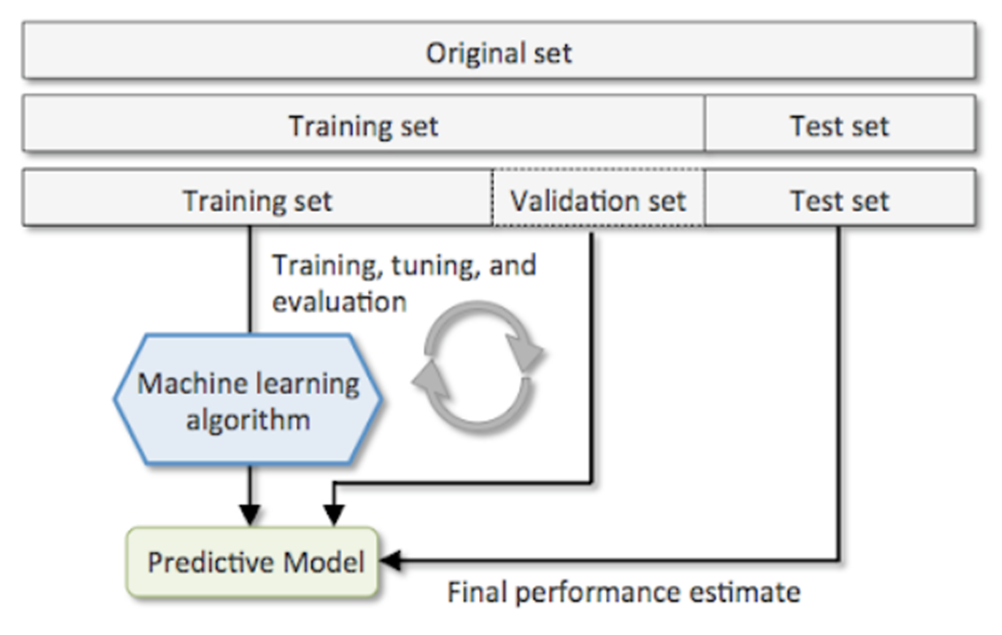

We hebben veel records, dus een **simple holdout-validation** zoals hierboven afgebeeld, is hier zeker mogelijk! We maken gebruik van Scikit-Learn functie `train_test_split` uit de module `model_selection` om de dataset op te splitsen in 80% trainingdata, 10% validatiedata en 10% testdata. We mogen niet vergeten om de kolom `'Speeding'` op te slaan in een apart DataFrame omdat dit de labels zijn!

In [ ]:
from sklearn.model_selection import train_test_split

y_df = df['Speeding']
X_df = df.drop('Speeding', axis=1)
X_df_train, X_df_rest, y_df_train, y_df_rest = train_test_split(X_df, y_df, train_size=0.8, random_state=0)
print(X_df_train.shape, y_df_train.shape)

(68909, 16) (68909,)


In [ ]:
X_df_val, X_df_test, y_df_val, y_df_test = train_test_split(X_df_rest, y_df_rest, test_size=0.5)
print(X_df_val.shape, y_df_val.shape)
print(X_df_test.shape, y_df_test.shape)

(8614, 16) (8614,)
(8614, 16) (8614,)


Merk op dat we de `random_state` opgeven omdat we dezelfde opdeling willen krijgen telkens we de notebook opnieuw runnen. Maar in de praktijk doe je dat liever niet!

We stoppen de namen van de kwantitatieve en kwalitatieve features in een aparte list. De kwantitatieve features zullen bij het toepassen van bepaalde algoritmes eerst genormaliseerd moeten worden. Bij de kwantitatieve features maken we een onderscheid tussen de binaire variabelen en de variabelen die meer dan 2 categorieën hebben omdat die laatste strings bevatten en dus moeten worden omgezet naar getallen.

In [ ]:
numerical = ['driver_age', 'TMIN', 'TMAX', 'AWND', 'WSF2']
binary = ['driver_gender', 'search_conducted', 'drugs_related_stop']
categorical = [column for column in X_df.columns if column not in numerical and column not in binary]
categorical

['year',
 'month',
 'day',
 'hour',
 'driver_race',
 'stop_outcome',
 'stop_duration',
 'weather']

## Modeling

Als we willen voorspellen of een bestuurder al dan niet een bekeuring heeft gekregen voor overdreven snelheid, dan hebben we hier te maken met **binaire classificatie**. Inderdaad, target variabele `'Speeding'` bestaat uit 2 klassen met labels `True` of `False`. Welke algoritmes kunnen we hiervoor toepassen? In de cursus hebben we de volgende classificatiealgoritmes besproken:

- Het perceptron algoritme
- Logistic regression
- K Nearest Neighbors
- Decision tree
- Naive Bayes

We gaan die algoritmes eens proberen toe te passen op onze dataset! De uitwerking voor het perceptron algoritme krijg je cadeau. Daarna ga je op een gelijkaardige manier te werk voor de overige 4 algoritmes.

### Perceptron

Een eerste algoritme voor binaire classificatie dat we in de cursus hebben gezien is het perceptron algoritme. Dat zit ingebouwd in Scikit-Learn. Maar eerst moeten we de features transformeren, want dat algoritme kan niet overweg met string inputvariabelen.

#### Feature encoding

We kunnen nu alle features stap voor stap gaan coderen zoals we in de vorige notebook hebben gedaan, maar dat is natuurlijk niet efficiënt. Daarom gaan we deze keer gebruik maken van Scikit-Learn klasse `ColumnTransformer`. Die geven we de list met numerieke variabelen mee die moeten herschaald worden met de `MinMaxScaler` en de list met categorische variabelen die moeten omgezet worden met de `OneHotEncoder`.

De binaire variabelen moeten niet meer omgezet worden want die bestaan al uit nullen en enen. De `ColumnTransformer` moet ze dus gewoon doorgeven zonder te transformeren. Vandaar dat we inputargument `'remainder'` gelijk stellen aan `'passthrough'`. Bestonden die binaire variabelen nog niet uit nullen en enen, dan hadden we die kunnen omzetten m.b.v. de `LabelEncoder`, zoals we hierboven hebben gedaan voor `driver_gender`.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# instantiëren
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical),    # numerieke variabelen herschalen
        ('cat', OneHotEncoder(), categorical)  # categorische variabelen omzetten naar one-hot encoding
    ], remainder='passthrough')                # de binaire variabelen moeten meegenomen worden!

# fitten - enkel adhv de trainingset!
preprocessor.fit(X_df_train)

# transformeren - alle datasets!
X_train = preprocessor.fit_transform(X_df_train).toarray()
X_val = preprocessor.transform(X_df_val).toarray()
X_test = preprocessor.transform(X_df_test).toarray()

# shapes checken
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(68909, 79)
(8614, 79)
(8614, 79)


**Let op!** Het fitten m.b.v. methode `fit()` mag enkel gebeuren aan de hand van de trainingset! Waarom is dat? Omdat we niet willen dat er informatie uit de validatie- of testset doorsijpelt naar het model. Neem bijvoorbeeld het herschalen. Om te vermijden dat de training beïnvloed wordt door de validatie- en testdata mogen we enkel de trainingsdata gebruiken om het minimum en maximum te bepalen. Die parameters worden berekend tijdens het fitten en dus mogen we hier enkel gebruik maken van de trainingset. Het effectief herschalen gebeurt tijdens het transformeren na aanroepen van methode `transform()`. Dat betekent dat validatie- en testset eveneens worden herschaald adhv minimum en maximum van de traininsdata, zoals het hoort!

Bemerk ook dat we methode `toarray()` aanroepen omdat een `sparse matrix` wordt geretourneerd. Dat is een matrix met heel veel nullen die enkel de getallen opslaat die niet gelijk zijn aan nul.

Het kan nuttig zijn om te weten dat de originele kolommen opgeslagen zijn in `features_names_in_`:

In [ ]:
preprocessor.feature_names_in_

array(['year', 'month', 'day', 'hour', 'driver_gender', 'driver_age',
       'driver_race', 'search_conducted', 'stop_outcome', 'stop_duration',
       'drugs_related_stop', 'weather', 'TMIN', 'TMAX', 'AWND', 'WSF2'],
      dtype=object)

Wil je weten in welke volgorde de categorieën van de categorische variabelen zijn omgezet? Dat kan op deze manier:

In [ ]:
preprocessor.named_transformers_['cat'].categories_

[array(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
        '2013', '2014', '2015'], dtype=object),
 array(['April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September'],
       dtype=object),
 array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
        'Wednesday'], dtype=object),
 array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8',
        '9'], dtype=object),
 array(['Asian', 'Black', 'Hispanic', 'Other', 'White'], dtype=object),
 array(['Arrest Driver', 'Arrest Passenger', 'Citation', 'N/D',
        'No Action', 'Warning'], dtype=object),
 array(['0-15 Min', '16-30 Min', '30+ Min'], dtype=object),
 array(['bad', 'good', 'worse'], dtype=object)]

Omdat onze features geconverteerd zijn naar NumPy arrays maken we ook van onze targets een NumPy array:

In [ ]:
y_train, y_val, y_test = y_df_train.values, y_df_val.values, y_df_test.values

We zijn klaar om het perceptron algoritme toe te passen.

#### Training en validatie

Laten we een eerste poging wagen! We passen het algoritme steeds toe op de trainingset, waarna we het bekomen model met optimale parameters evalueren aan de hand van zowel training- als validatieset. Wanneer de eerste veel beter scoort dan de tweede, dan is er sprake van overfitting.

In [ ]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(penalty=None,    # geen regularisatie
                        random_state=0)
perceptron.fit(X_train, y_train)
print('training acc:', perceptron.score(X_train, y_train))
print('validation acc:', perceptron.score(X_val, y_val))

training acc: 0.615536432106111
validation acc: 0.6059902484327838


We hebben geen duidelijke overfitting, maar het model voorspelt niet veel beter dan een dummy classifier, die we in de vorige notebook hebben toegepast. Laten we daarom eens uitzoeken of het veranderen van de learning rate een effect heeft. In de `Perceptron` klasse is dat inputparameter `eta0` die standaard gelijk is aan 1. We maken gebruik van een lus.

In [ ]:
import numpy as np

for eta in np.logspace(-5, 2, 8):
    print('eta =', eta)
    perceptron = Perceptron(penalty=None, eta0=eta)
    perceptron.fit(X_train, y_train)
    print('\ttraining acc:', perceptron.score(X_train, y_train))
    print('\tvalidation acc:', perceptron.score(X_val, y_val))

eta = 1e-05
	training acc: 0.5760640845172619
	validation acc: 0.5799860691896912
eta = 0.0001
	training acc: 0.5760640845172619
	validation acc: 0.5799860691896912
eta = 0.001
	training acc: 0.5760640845172619
	validation acc: 0.5799860691896912
eta = 0.01
	training acc: 0.5760640845172619
	validation acc: 0.5799860691896912
eta = 0.1
	training acc: 0.615536432106111
	validation acc: 0.6059902484327838
eta = 1.0
	training acc: 0.615536432106111
	validation acc: 0.6059902484327838
eta = 10.0
	training acc: 0.615536432106111
	validation acc: 0.6059902484327838
eta = 100.0
	training acc: 0.615536432106111
	validation acc: 0.6059902484327838


Er is niet echt verbetering in de nauwkeurigheid door de learning rate aan te passen.

#### Finale evaluatie

Laten we dus de default learning rate gelijk aan 1 nemen en finaal nog eens evalueren adhv de testset. De training doen we nu met zowel training- als validatieset omdat we een finale waarde voor de learning rate hebben gekozen.

In [ ]:
perceptron = Perceptron(penalty=None)
X, y = np.vstack((X_train, X_val)), np.hstack((y_train, y_val))
perceptron.fit(X, y)
print('training acc:', perceptron.score(X, y))
print('test acc:', perceptron.score(X_test, y_test))

training acc: 0.6249629142319054
test acc: 0.6184118876247968


We krijgen nu een hogere nauwkeurigheid, wat uiteraard mogelijk is omwille van het stochastisch karakter van het probleem dat we hier oplossen. Het is ook altijd interessant om een confusion matrix te plotten en een `classification_report` op te stellen. Daarvoor hebben we de voorspellingen nodig.

In [ ]:
# voorspellingen

yp = perceptron.predict(X)
yp_test = perceptron.predict(X_test)

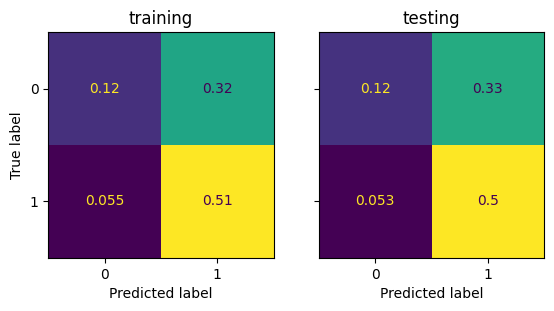

In [ ]:
# confusion matrices

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=yp,
                                        normalize='all', colorbar=False, ax=ax1);
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=yp_test,
                                        normalize='all', colorbar=False, ax=ax2);
ax1.set_title('training');
ax2.set_title('testing');
ax2.set_ylabel('');

In [ ]:
# classification reports

from sklearn.metrics import classification_report

print("training")
print(classification_report(y_true=y, y_pred=yp))

print("testing")
print(classification_report(y_true=y_test, y_pred=yp_test))

training
              precision    recall  f1-score   support

           0       0.68      0.27      0.39     33973
           1       0.61      0.90      0.73     43550

    accuracy                           0.62     77523
   macro avg       0.65      0.59      0.56     77523
weighted avg       0.64      0.62      0.58     77523

testing
              precision    recall  f1-score   support

           0       0.69      0.26      0.38      3846
           1       0.60      0.90      0.72      4768

    accuracy                           0.62      8614
   macro avg       0.65      0.58      0.55      8614
weighted avg       0.64      0.62      0.57      8614



We hebben geen overfitting, maar ons perceptron model doet het niet veel beter dan een dummy of random classifier. Laten we daarom eens logistic regression proberen en zien of dat een beter resultaat geeft.

### Logistic regression

Voer nu dezelfde stappen uit voor logistic regression. Pas geen regularisatie toe (`penalty=None`).

Hou er rekening mee dat Scikit-Learn geen gebruik maakt van Stochastic Gradient Descent, dus het heeft hier geen zin om de learning rate te onderzoeken. Het effect van eventuele andere hyperparameters gaan we niet onderzoeken, maar we kunnen wel de beste threshold zoeken voor het omzetten van voorspelde kansen naar labels. Die threshold kan ook als een hyperparameter worden gezien.

Onderzoek de drempelwaarde van 0.5 die standaard door Scikit-Learn wordt toegepast, en de threshold die je afleidt adhv de ROC-curve. Pas die threshold toe en evalueer adhv training- en validatieset. Kies de beste threshold en doe een finale evaluatie aan de hand van de testset.

#### Feature encoding

We passen dezelfde transformaties toe als bij het perceptron algoritme.

De labels omzetten naar arrays:

#### Training en validatie

Model trainen adhv trainingset en evalueren op training- en validatieset.

Het is in dit geval ook handig om een `classification_report` op te stellen om een zicht te krijgen op de precision en recall.

Om de ROC-curve te kunnen opstellen hebben we de voorspelde kansen op een positief label nodig.

Nu kunnen we de ROC curve plotten.

We krijgen een optimale threshold. Laten we opnieuw de classificatierapporten opstellen voor training- en validatieset waarbij we de labels voorspellen adhv deze drempelwaarde.

Is er een toename in nauwkeurigheid wanneer je die optimale threshold toepast? Wat verandert er precies? Welke van de twee thresholds kies je uiteindelijk en waarom?

*jouw antwoord*

#### Finale evaluatie

We hertrainen op de training- én validatieset, en nemen de threshold die best naar voren kwam uit de validatie.

De bijhorende confusion matrices:

En de classificatierapporten:

Wat besluit je?

*jouw antwoord*

### K nearest neighbors

Bij het KNN algoritme is het aantal nearest neighbors K de hyperparameter. Dus hier moet je K finetunen aan de hand van de validatieset.

#### Feature encoding

We passen opnieuw dezelfde transformaties toe als bij het perceptron algoritme.

De labels omzetten naar arrays:

#### Training en validatie

Een eerste poging met de defaultwaarde voor K:

Hier hebben we duidelijk overfitting, dus we gaan de optimale K proberen te zoeken door een range van waarden te overlopen. Voor elke waarde bepalen we de accuracy score voor zowel training- als validatieset, en we houden die scores bij in een afzonderlijke list.

Het resultaat plotten: de nauwkeurigheid op trainingset (blauwe lijn) en validatieset (rode lijn) in functie van K.

Wat besluit je uit de plot? Welke K waarde is optimaal en waarom?

*jouw antwoord*

#### Finale evaluatie

We voeren dus een finale training uit met de optimale K waarde, waarbij we training- en validatieset samenvoegen.

Laten we ook hier eens de confusion matrices plotten en de classification reports opstellen.

Wat besluit je?

*jouw antwoord*

### Decision tree

Probeer ook eens om een beslissingsboom op te stellen. Die zijn zeer gevoelig aan overfitting. Eén van de hyperparameters die je kan finetunen om dit te voorkomen is de diepte van de boom: `max_depth`.

In dit geval is het wellicht interessanter om de categorische features om te zetten naar integers ipv one-hot encoding toe te passen, en om de kwantitatieve features niet te herschalen. Het omzetten van categorische variabelen naar integers kan m.b.v. de Scikit-Learn klasse `OrdinalEncoder`.

#### Feature encoding

We gebruiken hier dus de `OrdinalEncoder` om de categorische non-binaire features om te zetten, en de kwantitatieve features worden niet herschaald.

De labels omzetten naar arrays:

#### Training en validatie

Een eerste poging met de defaultwaarden voor de hyperparameters:

Duidelijk overfitting! Laten we daarom de `max_depth` finetunen. Wat is de diepte in de beslissingsboom die we hierboven hebben getraind?

We trainen het model waarbij we de maximale diepte laten variëren van 1 t.e.m. 45. We houden voor elke training de nauwkeurigheid op de trainingset en op de validatieset bij in een list.

Het resultaat plotten: de nauwkeurigheid op trainingset (blauwe lijn) en validatieset (rode lijn) in functie de maximale diepte.

Wat besluit je uit de plot? Welke `max_depth` waarde is optimaal en waarom?

*jouw antwoord*

#### Finale evaluatie

We voeren een finale training uit met de optimale waarde voor `max_depth`, waarbij we training- en validatieset samenvoegen.

Laten we ook hier eens de confusion matrices plotten en de classification reports opstellen.

Wat besluit je?

*jouw antwoord*

### Naive Bayes

We hebben twee verschillende Naive Bayes algoritmes besproken in de les: `BernoulliNB` en `MultinomialNB`. Dan is er ook nog `CategoricalNB`. Strikt genomen kan je die algoritmes enkel toepassen bij categorische features, en dus gaan we enkel die features uit de dataset gebruiken en die omzetten m.b.v. one-hot encoding.

We gaan die algoritmes gebruiken om drie Naive Bayes modellen te trainen. We vergelijken adhv de validatieset en kiezen er één uit die we dan finaal gaan trainen en evalueren adhv de testset.

#### Feature encoding

Dus hier selecteren we enkel de categorische variabelen. De binaire variabelen moeten we niet meer omzetten; bij de andere passen we one-hot encoding toe.

De labels omzetten naar arrays:

#### Training en validatie

Maak gebruik van een `for` loop om de drie algoritmes te trainen en de resulterende modellen te valideren:

Wat besluit je?

*jouw antwoord*

#### Finale evaluatie

We doen een finale training met het Naive Bayes algoritme dat het meest nauwkeurige model opleverde. We voegen training- en validatieset samen.

Laten we ook hier eens de confusion matrices plotten en de classification reports opstellen.

Wat besluit je?

*jouw antwoord*

## Finale model

We hebben nu 5 soorten algoritmes toegepast op onze dataset met telkens een gefinetuned model als resultaat dat nog eens finaal werd geëvalueerd. In deze paragraaf kiezen we een finaal model dat wordt hertraind op de volledige dataset, d.w.z. de training-, de validatie- én de testset! Uiteraard gaan we dat finale model ook nog eens evalueren. Is die evaluatie positief, dan kan het model worden gebruikt om voorspellingen op nieuwe data uit te voeren. Eventueel wordt het zelfs gedeployed in een productieomgeving.

Welk model kies je uit de vijf die je hierboven hebt getraind, gevalideerd en finaal getest? Waarom?

*jouw antwoord*

Alvorens het gekozen model finaal te hertrainen moeten we natuurlijk eerst de data transformeren. Hier nemen we dus de volledige dataset!

We hertrainen het gekozen model met de optimale hyperparameter(s):

Laten we ook hier nog eens de confusion matrix plotten en een classification report opstellen.

Wat besluit je?

*jouw antwoord*

---